In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

Matplotlib is building the font cache; this may take a moment.
/ssd_scratch/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
casestore = dict()

In [9]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [

    dict(name="base", id="x4a1-base_mc", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    dict(name="new-defaults", id="x4a2-new_default_bcs", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    dict(name="tn_30eV", id="x4a3-tn_30ev", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    dict(name="fastbase", id="x5a1-quicker_base", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True)
]


for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                            double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                            unnormalise_geom = case["unnormalise_geom"])


CHECK: Total domain volume is 1.607E+00 [m3]
CHECK: Total domain volume is 1.607E+00 [m3]
CHECK: Total domain volume is 1.607E+00 [m3]
CHECK: Total domain volume is 1.607E+00 [m3]


In [4]:
%matplotlib inline

In [11]:
%matplotlib widget


# Check BCs

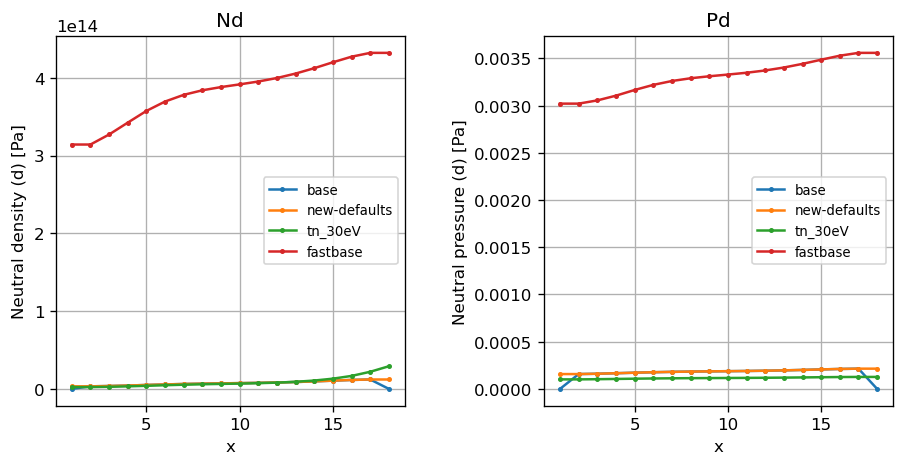

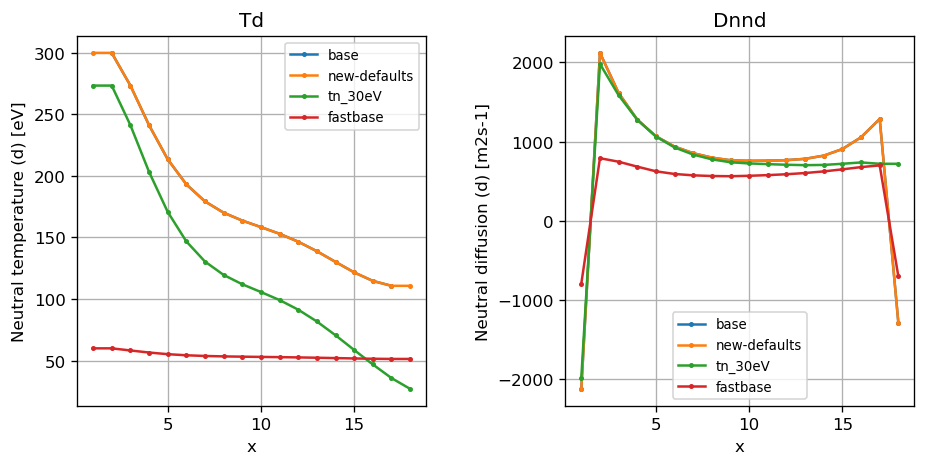

In [10]:
def plot(params):

    fig, axes = plt.subplots(1,len(params), figsize=(4.5*len(params),4), dpi=120)
    fig.subplots_adjust(wspace = 0.4)

    for i, param in enumerate(params):
        for casename in casestore:
            ds = casestore[casename].ds.isel(t=-1, x = slice(1,-1))
            omp = ds.hermesm.select_region("outer_midplane_a")

            (omp[param]).plot(ax = axes[i], marker = "o", label = casename, ms = 2)
            
        axes[i].grid()
        axes[i].set_title(param)
        axes[i].legend(fontsize = 8)
        axes[i].yaxis.set
        
plot(["Nd", "Pd"])
plot(["Td", "Dnnd"])

In [13]:
casestore["base"].ds.data_vars

Data variables:
    Bxy                 (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Dnnd                (t, x, theta) float64 dask.array<chunksize=(301, 20, 7), meta=np.ndarray>
    Ed+_iz              (t, x, theta) float64 dask.array<chunksize=(301, 20, 7), meta=np.ndarray>
    Ed+_rec             (t, x, theta) float64 dask.array<chunksize=(301, 20, 7), meta=np.ndarray>
    Edd+_cx             (t, x, theta) float64 dask.array<chunksize=(301, 20, 7), meta=np.ndarray>
    Fd+_iz              (t, x, theta) float64 dask.array<chunksize=(301, 20, 7), meta=np.ndarray>
    Fd+_rec             (t, x, theta) float64 dask.array<chunksize=(301, 20, 7), meta=np.ndarray>
    Fdd+_cx             (t, x, theta) float64 dask.array<chunksize=(301, 20, 7), meta=np.ndarray>
    G1                  (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    G2                  (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    G3                  (x, 

In [ ]:
toplot = dict()
# case_sel = ["fit_nsep3", "factor"]
case_sel = casestore.keys()
for casename in case_sel:
    toplot[casename] = casestore[casename].ds

lineplot(
    toplot,
    # params = ["Ne", "Td+", "Pd+", "NVd+"],
    params = ["Ne", "Td+", "Nd", "Td"],
    regions = ["field_line", "omp", "outer_lower"],
    # regions = ["omp"],
    scale = "log",
    dpi = 100
)

fastbase


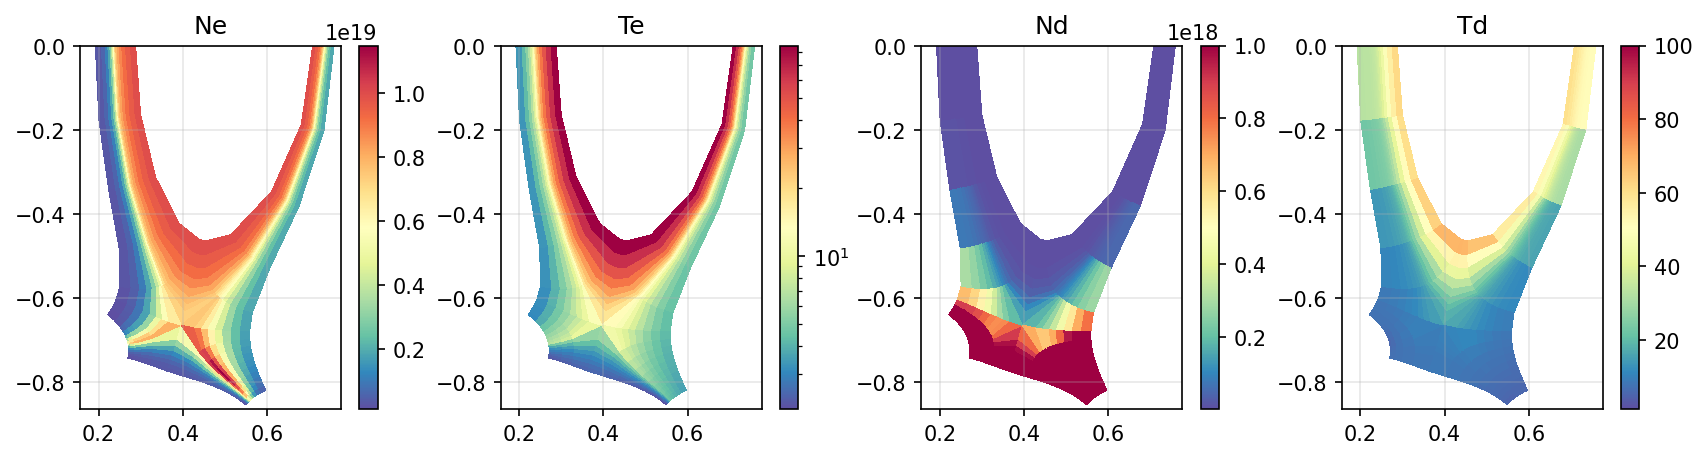

In [12]:
plt.close("all")
for casename in ["fastbase"]:
   print(casename)
   self = Monitor2D(casestore[casename], mode = "polygon", 
                    windows = [
                       ["Ne", "Te", "Nd", "Td"],
                     #   ["hf_perp_tot_R_d"],
                       ], 
                  settings = {
                     "all":{"view":"lower_divertor", "dpi": 150, "clean_guards":True},
                     "Ne":{"vmin":None, "vmax":None},
                     "Te":{"log":True, "vmin":None, "vmax":None},
                     "Td+":{"log":True, "vmin":None, "vmax":None},
                     "Nd":{"log":False, "vmax":1e18},
                     "Td":{"log":False, "vmin":1, "vmax":100},
                     "hf_perp_tot_R_d":{"log":True},
                     })

In [4]:
for name in casestore:
    casestore[name].ds = calculate_radial_fluxes(casestore[name].ds)
    casestore[name].ds = calculate_target_fluxes(casestore[name].ds)
    casestore[name].ds = calculate_heat_balance(casestore[name].ds)
    casestore[name].ds = calculate_particle_balance(casestore[name].ds)

In [13]:
name = "frenn"
ds = casestore[name].ds
ds = calculate_radial_fluxes(ds, force_neumann = False)
ds = calculate_target_fluxes(ds)
ds = calculate_heat_balance(ds)
ds = calculate_particle_balance(ds)

# plot_selection(ds, ds.hermesm.select_region("all_noguards"))

In [6]:
casestore.keys()

dict_keys(['base', 'new-defaults', 'tn_30eV'])

In [7]:
for name in ["new-defaults", "tn_30eV"]:
    print(name)
    ds = casestore[name].ds
    show_particle_balance_table(ds)
    show_heat_balance_table(ds)


new-defaults
---------------------------------------
PARTICLE BALANCE
---------------------------------------
Domain volume: 1.607e+00 [m3]
Particle imbalance: -1.018e+19 [s-1]
Particle imbalance as frac of core + source: -0.40%
---------------------------------------
Total fluxes in [s-1]:


,d+,d,total
source,0.00e+00,0.00e+00,0.00e+00
core,2.54e+21,0.00e+00,2.54e+21
sol,0.00e+00,0.00e+00,0.00e+00
pfr,0.00e+00,0.00e+00,0.00e+00
targets,-5.11e+22,4.85e+22,-2.55e+21
iz,4.85e+22,-4.85e+22,0.00e+00
rec,-3.59e+18,3.59e+18,0.00e+00


---------------------------------------
HEAT BALANCE
---------------------------------------
Domain volume: 1.607e+00 [m3]
Power in: 1.729 [MW]
Power out: -1.808 [MW]
Power imbalance: -0.079 [MW]
Power imbalance as frac of power in: -4.58%
---------------------------------------
Total fluxes in [MW]:


,d,e,d+,total
source,0.00,0.00,0.00,0.00
core,0.00,0.89,0.84,1.73
sol,-0.00,-0.00,0.00,0.00
pfr,0.00,0.00,0.00,0.00
targets,0.00,-0.66,-0.94,-1.60
rad_ex,nan,-0.20,nan,-0.20
rad_rec,nan,-0.00,nan,-0.00


tn_30eV
---------------------------------------
PARTICLE BALANCE
---------------------------------------
Domain volume: 1.607e+00 [m3]
Particle imbalance: -1.035e+19 [s-1]
Particle imbalance as frac of core + source: -0.42%
---------------------------------------
Total fluxes in [s-1]:


,d+,d,total
source,0.00e+00,0.00e+00,0.00e+00
core,2.49e+21,0.00e+00,2.49e+21
sol,0.00e+00,0.00e+00,0.00e+00
pfr,0.00e+00,0.00e+00,0.00e+00
targets,-5.00e+22,4.75e+22,-2.50e+21
iz,4.74e+22,-4.74e+22,0.00e+00
rec,-3.10e+18,3.10e+18,0.00e+00


---------------------------------------
HEAT BALANCE
---------------------------------------
Domain volume: 1.607e+00 [m3]
Power in: 1.774 [MW]
Power out: -1.890 [MW]
Power imbalance: -0.116 [MW]
Power imbalance as frac of power in: -6.69%
---------------------------------------
Total fluxes in [MW]:


,d,e,d+,total
source,0.00,0.00,0.00,0.00
core,0.00,0.90,0.84,1.73
sol,0.04,-0.00,-0.00,0.04
pfr,0.00,0.00,-0.00,-0.00
targets,0.00,-0.68,-1.02,-1.69
rad_ex,nan,-0.20,nan,-0.20
rad_rec,nan,-0.00,nan,-0.00


---------------------------------------
HEAT BALANCE
---------------------------------------
Domain volume: 1.607e+00 [m3]
Power in: 3.717 [MW]
Power out: -3.875 [MW]
Power imbalance: -0.158 [MW]
Power imbalance as frac of core + source: -4.26%
---------------------------------------
Total fluxes in [MW]:


,d,e,d+,total
source,0.00,0.00,0.00,0.00
core,0.00,1.75,1.97,3.72
sol,-0.04,-0.00,0.00,-0.04
pfr,0.00,0.00,-0.00,-0.00
targets,0.00,-1.50,-1.86,-3.36
rad_ex,nan,-0.47,nan,-0.47
rad_rec,nan,-0.00,nan,-0.00


<class 'list'>
<class 'list'>


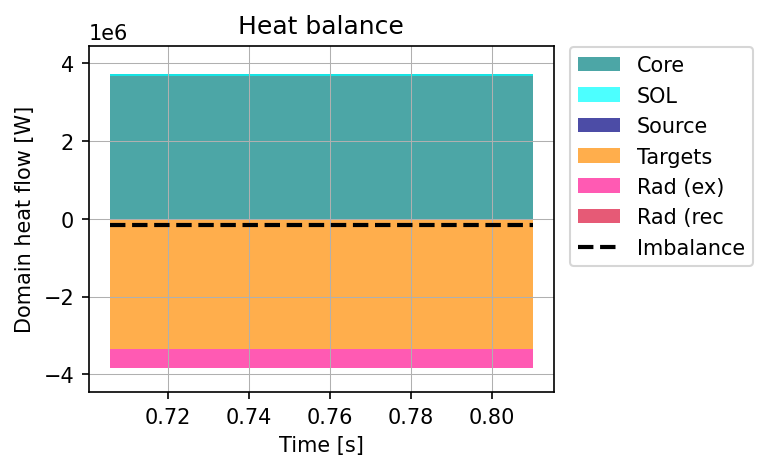

In [20]:
# import warnings
# warnings.simplefilter('ignore', RuntimeWarning)
show_heat_balance_table(ds)
plot_heat_balance(ds)

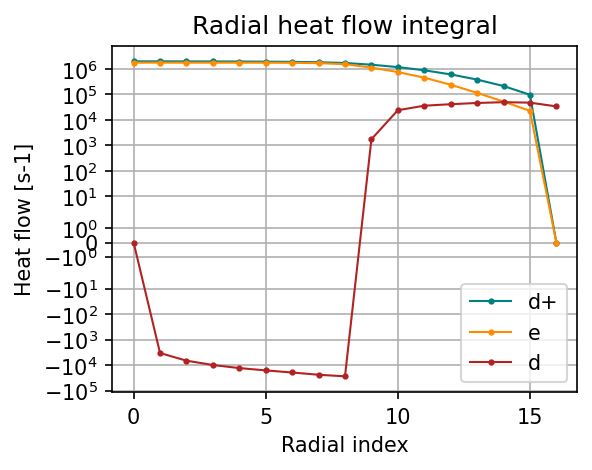

In [17]:
plot_perp_heat_fluxes(ds.isel(t=-1))

In [ ]:
impose_fields(
    source = r"/ssd_scratch/hcases/g3b1-lores_newhypno.nc",
    destination = r"/ssd_scratch/hcases/g3b1f2-mbtest.nc",
    Ni_src_core = 8.53e21,
    Pi_src_core = 1.33e6 * 2/3,
    Pe_src_core = 1.28e6 * 2/3,
    
)

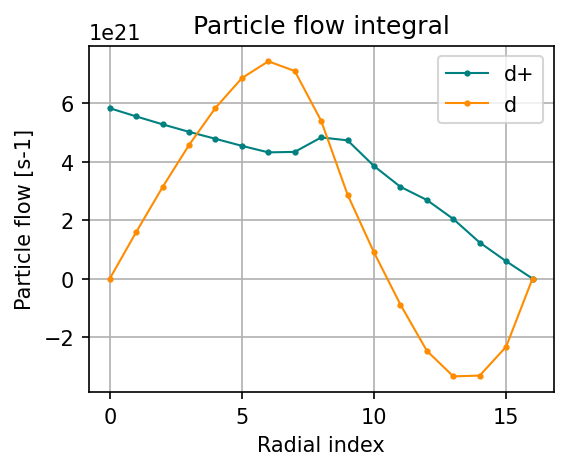

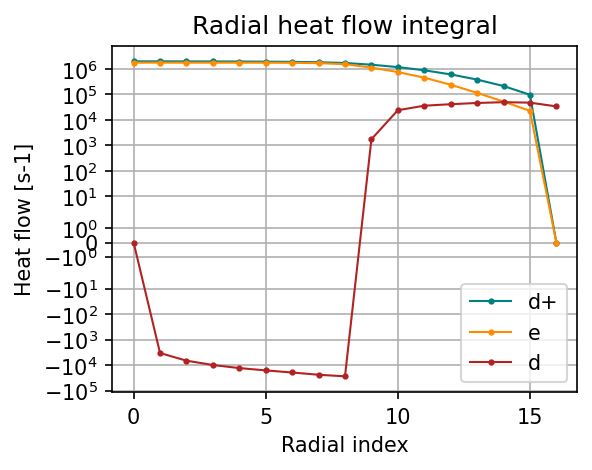

In [18]:
# plot_perp_particle_fluxes(casestore["no_neutrals"].ds.isel(t=-1))
plot_perp_particle_fluxes(casestore["frenn"].ds.isel(t=-1))
plot_perp_heat_fluxes(casestore["frenn"].ds.isel(t=-1))

In [75]:
%matplotlib widget

In [ ]:
plt.close("all")
v = viewer_2d(
    "hf_perp_tot_L_d",
    cases = {
        "st40_process" : {"code":"hermes", "ds":casestore["st40_process"].ds}
    },
    vmin = 1,
)

In [ ]:
plt.close("all")
self = Monitor2D(casestore["compasslike"], mode = "polygon", windows = [["Td", "Nd", "pf_perp_diff_d"]], 
                 settings = {
                    "all":{"view":None, "dpi": 120, "clean_guards":True},
                    "Ne":{"vmin":None, "vmax":None},
                    "Te":{"log":True, "vmin":10, "vmax":100},
                    "Td+":{"log":True, "vmin":10, "vmax":100},
                    "Nd":{"log":False, "vmax":1e18},
                    })

# Plot OMP profiles

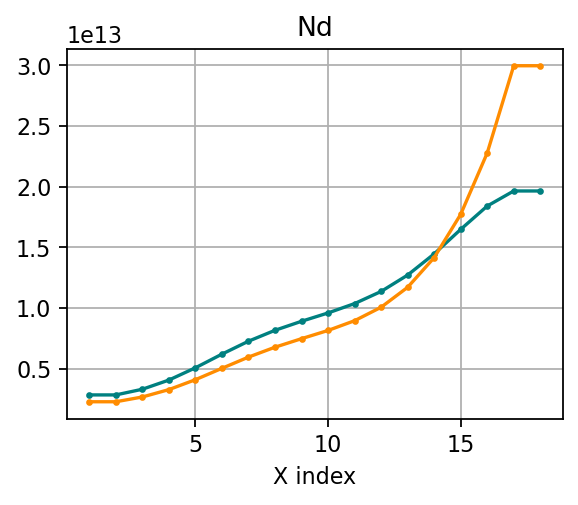

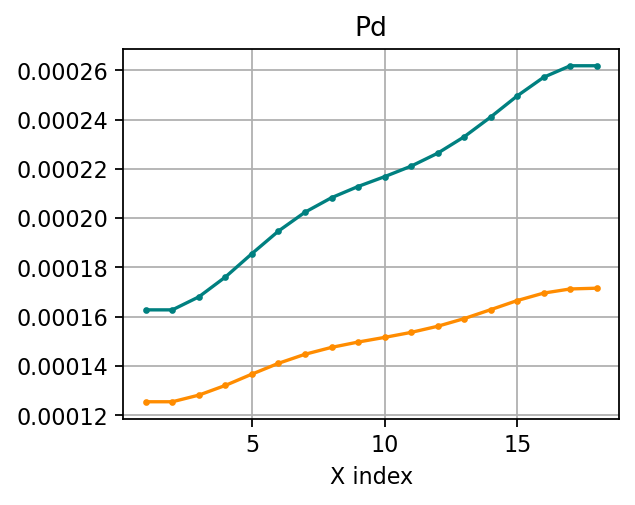

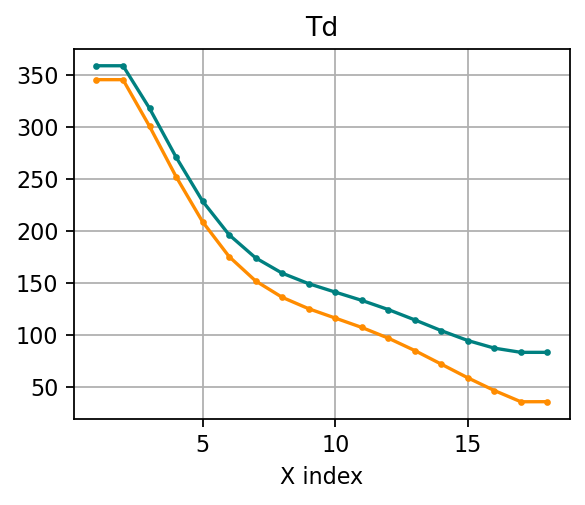

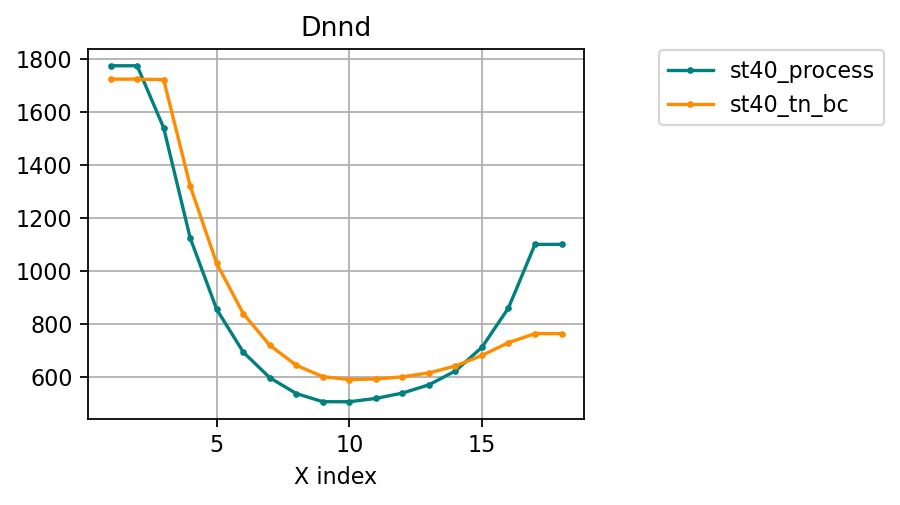

In [8]:
toplot = ["st40_process", "st40_tn_bc"]
lslist = ["-", "--", ":"]
mlist = ["o", "v", "x"]
for param in ["Nd", "Pd", "Td", "Dnnd"]:
    
    fig, ax = plt.subplots(figsize=(4,3), dpi = 160)
    for i, casename in enumerate(toplot):
        if casename != "allneumann":
            ds = casestore[casename].ds.isel(x=slice(1,-1))
            # d = ds.isel(t=-1, x=slice(2,-2)).sum("theta")
            d = ds.isel(t=-1).hermesm.select_region("outer_midplane_a")

            d[param].plot(ax = ax, marker = "o", ms = 2, c = ds.metadata["colors"][i], label = casename)

            # ax2 = ax.twinx()
            # ax2.plot(d.coords["x"], d["Sd+_iz"],  marker = "o", label = "iz (RHS)", ms = 0, c = "grey", ls = "--")

    ax.set_title(param)
    ax.set_xlabel("X index")
    ax.set_ylabel("")
    ax.grid()
fig.legend(loc = "upper left", bbox_to_anchor=(1.0, 0.9))

# Post-processing

st40_process


Exception: Plot avg_density not available

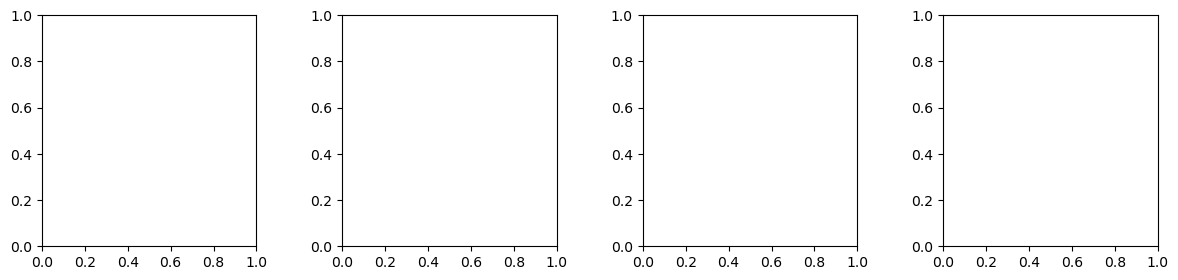

In [48]:
for casename in casestore.keys():
    print(casename)
    Monitor(casestore[casename], [["avg_density", "avg_temp", "target_temp","radiation"],
                                  ["sep_ne", "sep_te"]
                ])

{'xlim': (None, None), 'ylim': (None, None), 'figure_aspect': 0.9, 'wspace_modifier': 1, 'view': 'lower_divertor', 'dpi': 100}


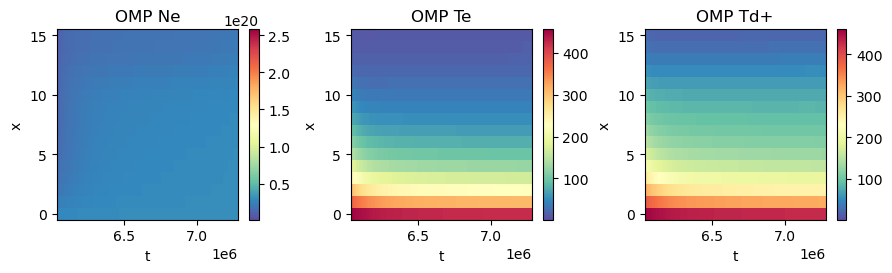

In [5]:
self = Monitor2D(caseng, mode = "omp_history", windows = [["Ne", "Te", "Td+"]], 
                 settings = {
                    "all":{"view":"lower_divertor", "dpi": 100},
                    "Ne":{"vmax":None},
                    "Te":{"vmin":None, "vmax":None},
                    "Td+":{"vmin":None, "vmax":None},
                    })

{'xlim': (None, None), 'ylim': (None, None), 'figure_aspect': 0.9, 'wspace_modifier': 1, 'view': 'None', 'dpi': 150}


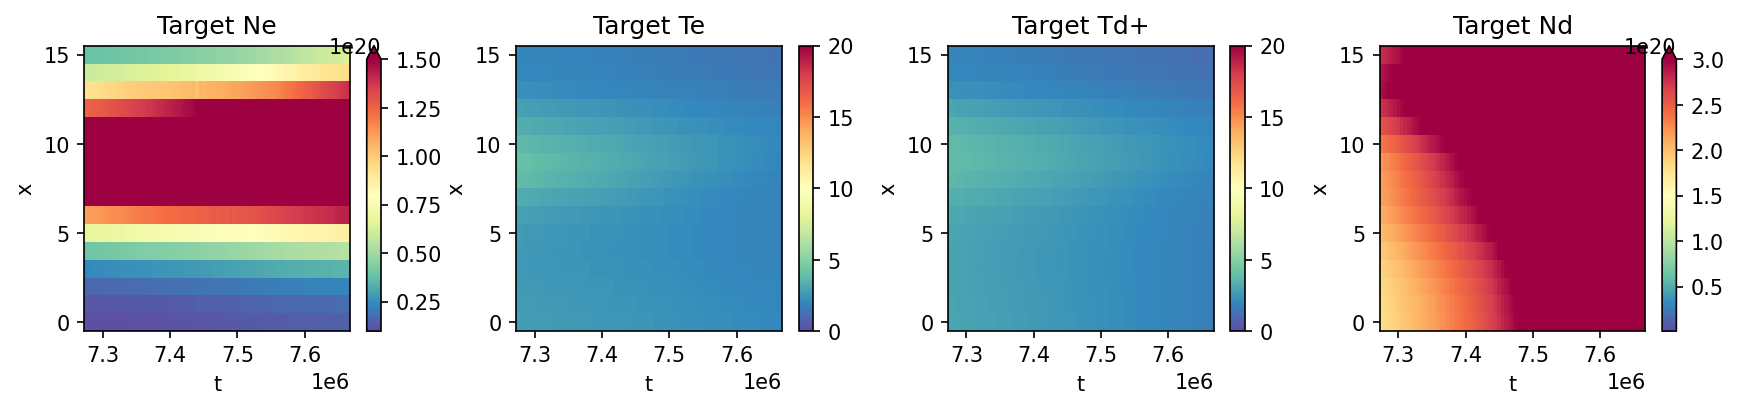

In [5]:
self = Monitor2D(caseng, mode = "target_history", windows = [["Ne", "Te", "Td+", "Nd"]], 
                 settings = {
                    "all":{"view":"None", "dpi": 150},
                    "Ne":{"vmax":15e19},
                    "Te":{"vmin":0, "vmax":20},
                    "Td+":{"vmin":0, "vmax":20},
                    "Nd":{"vmin":1e18, "vmax":3e20}
                    })

{'xlim': (None, None), 'ylim': (None, None), 'figure_aspect': 0.9, 'wspace_modifier': 1, 'view': None, 'dpi': 100}


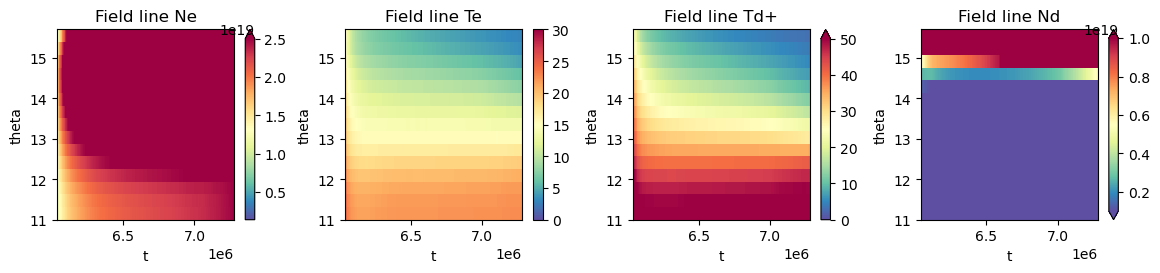

In [7]:
self = Monitor2D(caseng, mode = "field_line_history", windows = [["Ne", "Te", "Td+", "Nd"]], 
                 settings = {
                  #   "all":{"view":"lower_divertor", "dpi": 100},
                    "Ne":{"vmax":2.5e19},
                    "Te":{"vmin":0, "vmax":30},
                    "Td+":{"vmin":0, "vmax":50},
                    "Nd":{"vmin":1e18, "vmax":1e19}
                    })

In [11]:
caseng.unnormalise(unnormalise_geom=False)

--> dx, dy and J will not be unnormalised


{'xlim': (None, None), 'ylim': (None, None), 'figure_aspect': 0.9, 'wspace_modifier': 1, 'view': None, 'dpi': 100}


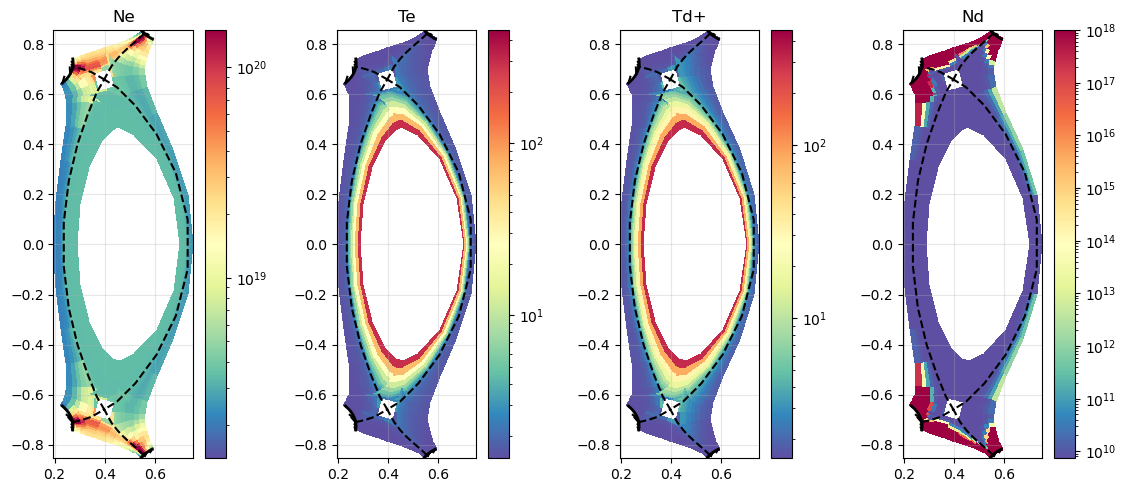

In [16]:
self = Monitor2D(caseng, mode = "pcolor", windows = [["Ne", "Te", "Td+", "Nd"]], 
                 settings = {
                    "all":{"view":None, "dpi": 100},
                    "Sd_src":{"log":False},
                    "Ne":{"vmin":None, "vmax":15e19},
                    "Te":{"log":True, "vmin":None, "vmax":None},
                    "Td+":{"log":True, "vmin":None, "vmax":None},
                    "Nd":{"log":True, "vmin":None, "vmax":1e18}
                    })